### Autoreload

In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

In [38]:
# Task models
from dlomix.models.chargestate import DominantChargeStatePredictor # Task 1
from dlomix.models.chargestate import ObservedChargeStatePredictor # Task 2
from dlomix.models.chargestate import ChargeStateProportionPredictor # Task 3


# Test models
from dlomix.models.experimental_chargestate import PrositChargeStateAdaption
from dlomix.models.experimental_chargestate import DominantChargeStatePredictorTest
from dlomix.models.experimental_chargestate import DominantChargeStatePredictor_nativeAttention

# Constants
from dlomix.constants import ALPHABET_UNMOD

# libraries
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd 
import numpy as np 
# 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import classification_report, confusion_matrix

## Create dummy data

In [3]:
# read in parquet file
df = pd.read_parquet('../data/TUM_third_pool_meta_data.parquet')

In [4]:
# remove UNIMOD sequences
df = df[~df.modified_sequence.str.contains('UNIMOD')]

In [5]:
# randomly sample 10,000 rows
df = df.sample(10000)

In [6]:
# encode the sequences
df.modified_sequence = df.modified_sequence.apply(list).apply(lambda x: np.array([ALPHABET_UNMOD[aa] for aa in x]))

In [7]:
# determine the maximum sequence length in the dummy-dataset
max_len = df.modified_sequence.apply(len).max()
max_len

32

In [8]:
# pad sequences to max length with 0s
df.modified_sequence = df.modified_sequence.apply(lambda x: np.pad(x, (0, max_len - len(x)), constant_values=0))

In [9]:
# drop all column exept modified_sequence and precursor_charge
df = df[['modified_sequence', 'precursor_charge']]

In [10]:
# Split into features and labels
X = np.array(df.modified_sequence.to_list())
y = df['precursor_charge'].values

# Split into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Load preprocessed data

In [11]:
processed_data = pd.read_parquet("/mnt/c/Users/Florian/Desktop/Uni/MSc/FoPr/preprocessed_pcp_data.parquet")

In [12]:
processed_data.head()

,modified_sequence,precursor_charge,precursor_intensity,charge_by_max_intensity,max_intensity,charge_by_avg_intensity,avg_intensity,one_hot_most_abundant_charge,charge_state_vector,normalized_intensity_distribution
0,AAAAAAAAAAAAAAAAGLGLGP,"[2, 3, 2, 1, 1, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, ...","[12746190.0, 2009914.0, 12746190.0, 791369.9, ...",2,84118390.0,2,4.312718e+07,"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 0, 0, 0]","[0.0014942136737631886, 0.977159622342211, 0.0..."
1,AAAAAAAAAAAAAAAASAGGK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[5944787.0, 5944787.0, 8502878.0, 6425294.0, 8...",2,8824163.0,2,7.635637e+06,"[0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
2,AAAAAAAAAAAAAAAGAGAGAK,"[2, 2, 2, 2]","[3067981.0, 3067981.0, 3067981.0, 3067981.0]",2,3067981.0,2,3.067981e+06,"[0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
3,AAAAAAAAAAAAAAASGFAYPGTSER,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3]","[11913300.0, 11913300.0, 11913300.0, 11913300....",2,11913300.0,2,8.273927e+06,"[0, 1, 0, 0, 0, 0]","[0, 1, 1, 0, 0, 0]","[0.0, 0.9879325512697509, 0.012067448730249095..."
4,AAAAAAAAAAAAAAG,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1573785.0, 4638296.0, 7934979.0, 2019978.0, 4...",1,16573010.0,1,8.562738e+06,"[1, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [13]:
len(processed_data)

757820

In [14]:
simplified_processed_data = processed_data.sample(1000)

In [15]:
# remove UNIMOD sequences
simplified_processed_data = processed_data[~processed_data.modified_sequence.str.contains('UNIMOD')]

In [16]:
# encode the sequences
simplified_processed_data.modified_sequence = simplified_processed_data.modified_sequence.apply(list).apply(lambda x: np.array([ALPHABET_UNMOD[aa] for aa in x]))

/tmp/ipykernel_236057/390376040.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simplified_processed_data.modified_sequence = simplified_processed_data.modified_sequence.apply(list).apply(lambda x: np.array([ALPHABET_UNMOD[aa] for aa in x]))


In [17]:
# determine the maximum sequence length in the dummy-dataset
max_len = simplified_processed_data.modified_sequence.apply(len).max()
max_len

40

In [18]:
# pad sequences to max length with 0s
simplified_processed_data.modified_sequence = simplified_processed_data.modified_sequence.apply(lambda x: np.pad(x, (0, max_len - len(x)), constant_values=0))

/tmp/ipykernel_236057/266666972.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simplified_processed_data.modified_sequence = simplified_processed_data.modified_sequence.apply(lambda x: np.pad(x, (0, max_len - len(x)), constant_values=0))


In [19]:
# drop all column exept modified_sequence and precursor_charge
simplified_processed_data = simplified_processed_data[['modified_sequence', 'one_hot_most_abundant_charge', 'charge_state_vector', 'normalized_intensity_distribution']]

### majority model data

In [20]:
majority_X = np.array(simplified_processed_data.modified_sequence.to_list())
majority_y = np.array(simplified_processed_data['one_hot_most_abundant_charge'].tolist())

# 70/20/10 split for training, validation and test
# First split: training and test+validation
majority_X_train, majority_X_test, majority_y_train, majority_y_test = train_test_split(majority_X, majority_y, test_size=0.3, random_state=42)

# Second split: test and validation
majority_X_test, majority_X_val, majority_y_test, majority_y_val = train_test_split(majority_X_test, majority_y_test, test_size=0.33, random_state=42)

# Check the shape of the splits 
print("Training set shape: ", majority_X_train.shape, majority_y_train.shape)
print("Validation set shape: ", majority_X_val.shape, majority_y_val.shape)
print("Test set shape: ", majority_X_test.shape, majority_y_test.shape)

Training set shape:  (370345, 40) (370345, 6)
Validation set shape:  (52378, 40) (52378, 6)
Test set shape:  (106342, 40) (106342, 6)


### oserved model data 

In [21]:
observed_X = np.array(simplified_processed_data.modified_sequence.to_list())
observed_y = np.array(simplified_processed_data['charge_state_vector'].tolist())

# 70/20/10 split for training, validation and test
# First split: training and test+validation
observed_X_train, observed_X_temp, observed_y_train, observed_y_temp = train_test_split(observed_X, observed_y, test_size=0.3, random_state=42)

# Second split: validation and test
observed_X_val, observed_X_test, observed_y_val, observed_y_test = train_test_split(observed_X_temp, observed_y_temp, test_size=1/3, random_state=42)

# Check the shape of the splits
print("Training set shape:", observed_X_train.shape, observed_y_train.shape)
print("Validation set shape:", observed_X_val.shape, observed_y_val.shape)
print("Test set shape:", observed_X_test.shape, observed_y_test.shape)

Training set shape: (370345, 40) (370345, 6)
Validation set shape: (105813, 40) (105813, 6)
Test set shape: (52907, 40) (52907, 6)


### distribution model data 

In [39]:
distribution_X = np.array(simplified_processed_data.modified_sequence.to_list())
distribution_y = np.array(simplified_processed_data['normalized_intensity_distribution'].tolist())

# 70/20/10 split for training, validation and test
# First split: training and test+validation
distribution_X_train, distribution_X_temp, distribution_y_train, distribution_y_temp = train_test_split(distribution_X, distribution_y, test_size=0.3, random_state=42)

# Second split: validation and test
distribution_X_val, distribution_X_test, distribution_y_val, distribution_y_test = train_test_split(distribution_X_temp, distribution_y_temp, test_size=1/3, random_state=42)

# Check the shape of the splits
print("Training set shape:", distribution_X_train.shape, distribution_y_train.shape)
print("Validation set shape:", distribution_X_val.shape, distribution_y_val.shape)
print("Test set shape:", distribution_X_test.shape, distribution_y_test.shape)

Training set shape: (370345, 40) (370345, 6)
Validation set shape: (105813, 40) (105813, 6)
Test set shape: (52907, 40) (52907, 6)


## Create task model objects

In [23]:
majority_charge_model = DominantChargeStatePredictor()
majority_charge_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2024-04-22 18:52:41.523284: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-22 18:52:41.562159: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-22 18:52:41.562194: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-22 18:52:41.565837: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-22 18:52:41.566038: I external/local_xla/xla/stream_executor

In [24]:
observed_charges_model = ObservedChargeStatePredictor()
observed_charges_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
charge_distribution_model = ChargeStateProportionPredictor()
charge_distribution_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

## Regularization

In [26]:
# Early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

In [27]:
# Decaying learning rate
def scheduler(epoch, lr):
    if epoch < 4:
        return lr
    else:
        return lr * np.exp(-0.1)

decaying_lr = LearningRateScheduler(scheduler)

## -----------------------------------------------------------------------------------------------------------------------------------------------------
# Train models on dummy data // purposefully overfitting

In [28]:
majority_charge_model(majority_X_train[0].reshape(1, -1))

2024-04-22 18:52:42.149118: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[0.16598502, 0.16653655, 0.1663775 , 0.16742913, 0.16650537,
        0.16716643]], dtype=float32)>

In [29]:
majority_charge_model_history = majority_charge_model.fit(majority_X_train, majority_y_train, validation_data=(majority_X_val, majority_y_val), epochs=50, batch_size=32)

Epoch 1/50


2024-04-22 18:52:43.071556: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f85c9b8df90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-22 18:52:43.071581: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-04-22 18:52:43.075306: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1713804763.114998  236412 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11574/11574 [==============================] - 71s 6ms/step - loss: 0.2269 - accuracy: 0.9112 - val_loss: 0.1930 - val_accuracy: 0.9279
Epoch 2/50
11574/11574 [==============================] - 80s 7ms/step - loss: 0.1887 - accuracy: 0.9278 - val_loss: 0.1825 - val_accuracy: 0.9316
Epoch 3/50
11574/11574 [==============================] - 74s 6ms/step - loss: 0.1773 - accuracy: 0.9330 - val_loss: 0.1737 - val_accuracy: 0.9375
Epoch 4/50
11574/11574 [==============================] - 70s 6ms/step - loss: 0.1704 - accuracy: 0.9365 - val_loss: 0.1710 - val_accuracy: 0.9374
Epoch 5/50
11574/11574 [==============================] - 68s 6ms/step - loss: 0.1649 - accuracy: 0.9388 - val_loss: 0.1748 - val_accuracy: 0.9368
Epoch 6/50
11574/11574 [==============================] - 69s 6ms/step - loss: 0.1595 - accuracy: 0.9413 - val_loss: 0.1813 - val_accuracy: 0.9357
Epoch 7/50
11574/11574 [==============================] - 66s 6ms/step - loss: 0.1546 - accuracy: 0.9432 - val_loss: 0.1829 - val

In [30]:
observed_charges_model(observed_X_train[0].reshape(1, -1))

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[0.5014801 , 0.49991584, 0.50196123, 0.49866652, 0.4985577 ,
        0.50058955]], dtype=float32)>

In [31]:
observed_charges_model_history = observed_charges_model.fit(observed_X_train, observed_y_train, validation_data=(observed_X_val, observed_y_val), epochs=50, batch_size=32)

Epoch 1/50
11574/11574 [==============================] - 59s 5ms/step - loss: 0.1109 - accuracy: 0.7186 - val_loss: 0.0991 - val_accuracy: 0.7064
Epoch 2/50
11574/11574 [==============================] - 54s 5ms/step - loss: 0.0983 - accuracy: 0.7126 - val_loss: 0.0984 - val_accuracy: 0.7445
Epoch 3/50
11574/11574 [==============================] - 54s 5ms/step - loss: 0.0938 - accuracy: 0.7105 - val_loss: 0.0934 - val_accuracy: 0.7060
Epoch 4/50
11574/11574 [==============================] - 54s 5ms/step - loss: 0.0911 - accuracy: 0.7120 - val_loss: 0.0925 - val_accuracy: 0.7030
Epoch 5/50
11574/11574 [==============================] - 54s 5ms/step - loss: 0.0885 - accuracy: 0.7142 - val_loss: 0.0933 - val_accuracy: 0.7185
Epoch 6/50
11574/11574 [==============================] - 54s 5ms/step - loss: 0.0859 - accuracy: 0.7156 - val_loss: 0.0930 - val_accuracy: 0.7173
Epoch 7/50
11574/11574 [==============================] - 55s 5ms/step - loss: 0.0833 - accuracy: 0.7177 - val_loss: 0

In [41]:
charge_distribution_model(distribution_X_train[0].reshape(1, -1))

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[0.49825114, 0.4981406 , 0.5006202 , 0.50114113, 0.49839905,
        0.4978419 ]], dtype=float32)>

In [42]:
charge_distribution_model_history = charge_distribution_model.fit(distribution_X_train, distribution_y_train, validation_data=(distribution_X_val, distribution_y_val), epochs=50, batch_size=32)

Epoch 1/50
11574/11574 [==============================] - 60s 5ms/step - loss: 0.0162 - accuracy: 0.9006 - val_loss: 0.0130 - val_accuracy: 0.9181
Epoch 2/50
11574/11574 [==============================] - 55s 5ms/step - loss: 0.0129 - accuracy: 0.9180 - val_loss: 0.0121 - val_accuracy: 0.9231
Epoch 3/50
11574/11574 [==============================] - 57s 5ms/step - loss: 0.0121 - accuracy: 0.9218 - val_loss: 0.0118 - val_accuracy: 0.9236
Epoch 4/50
11574/11574 [==============================] - 55s 5ms/step - loss: 0.0116 - accuracy: 0.9250 - val_loss: 0.0116 - val_accuracy: 0.9233
Epoch 5/50
11574/11574 [==============================] - 54s 5ms/step - loss: 0.0112 - accuracy: 0.9265 - val_loss: 0.0120 - val_accuracy: 0.9215
Epoch 6/50
11574/11574 [==============================] - 53s 5ms/step - loss: 0.0109 - accuracy: 0.9289 - val_loss: 0.0113 - val_accuracy: 0.9259
Epoch 7/50
11574/11574 [==============================] - 54s 5ms/step - loss: 0.0105 - accuracy: 0.9314 - val_loss: 0

In [49]:
majority_X_train[0, :].shape

(40,)

## -----------------------------------------------------------------------------------------------------------------------------------------------------
# Reporting
## -----------------------------------------------------------------------------------------------------------------------------------------------------

In [34]:
def plot_learning_curves(history, title='Learning Curves'):
    """Plot the learning curves for training and validation loss and accuracy. 
    Args:
    - history: Return value from model.fit().
    - title (optional): Base title for the plots. It will be appended with "Loss" and "Accuracy" for the respective plots.
    """
    history_dict = history.history
    loss = history_dict['loss']
    val_loss = history_dict.get('val_loss', [])
    
    epochs = range(1, len(loss) + 1)
    
    accuracy_key = next((key for key in history_dict.keys() if 'acc' in key and not key.startswith('val_')), None)
    val_accuracy_key = next((key for key in history_dict.keys() if 'acc' in key and key.startswith('val_')), None)
    learning_rate = history_dict.get('lr', [])
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot training and validation loss
    ax1.plot(epochs, loss, 'b', label='Training Loss')
    if val_loss:
        ax1.plot(epochs, val_loss, 'r', label='Validation Loss')
    ax1.set_title(f'{title} - Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot training and validation accuracy if keys exist
    if accuracy_key and val_accuracy_key:
        accuracy = history_dict[accuracy_key]
        val_accuracy = history_dict[val_accuracy_key]
        ax2.plot(epochs, accuracy, 'b', label='Training Accuracy')
        ax2.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
        ax2.set_title(f'{title} - Accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
    else:
        ax2.set_title(f'{title} - Accuracy Not Available')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.text(0.5, 0.5, 'Accuracy data not found in history', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)
    
    # Plot learning rate
    if learning_rate:
        ax3.plot(epochs, learning_rate, 'g', label='Learning Rate')
        ax3.set_title(f'{title} - Learning Rate')
        ax3.set_xlabel('Epochs')
        ax3.set_ylabel('Learning Rate')
        ax3.legend()
    else:
        ax3.set_title(f'{title} - Learning Rate Not Available')
        ax3.set_xlabel('Epochs')
        ax3.set_ylabel('Learning Rate')
        ax3.text(0.5, 0.5, 'Learning rate data not found in history', horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes)

    
    plt.tight_layout()
    plt.show()

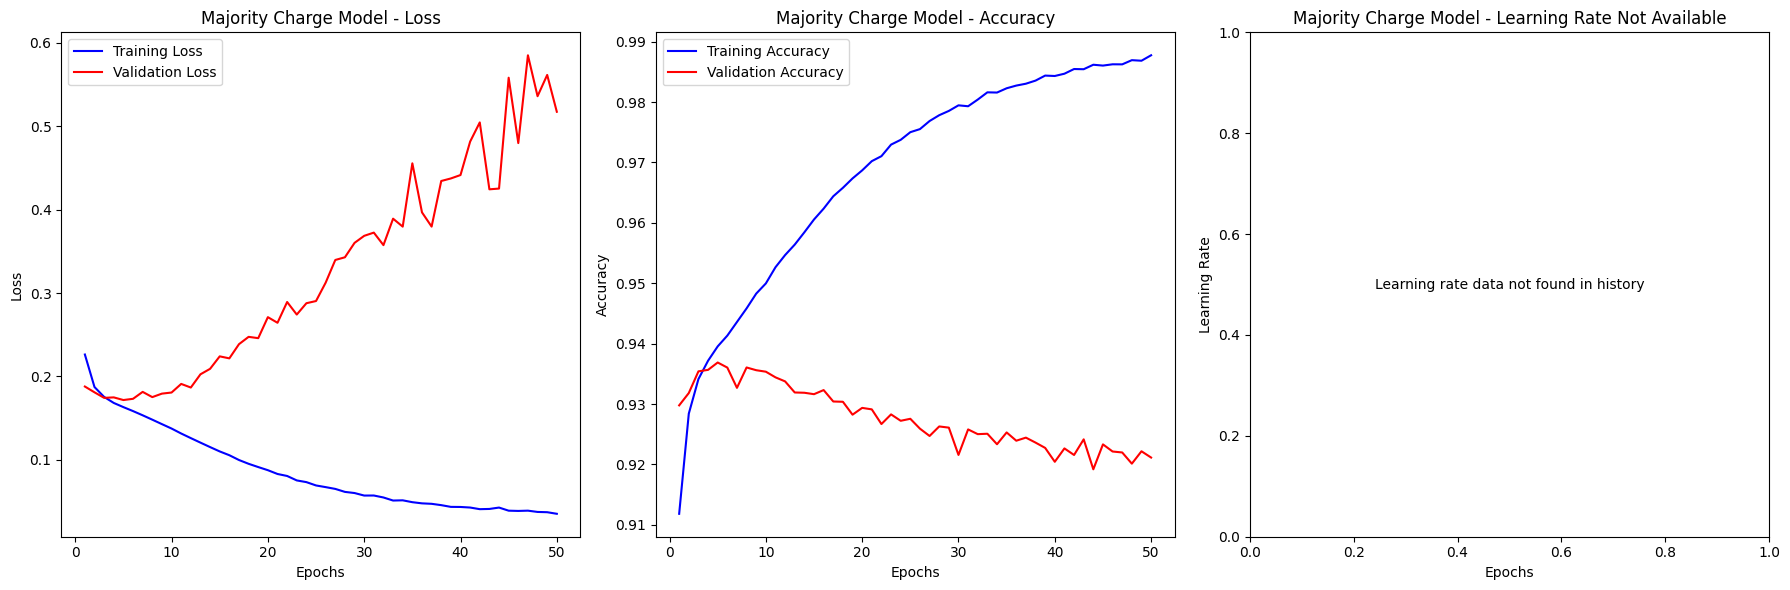

In [213]:
plot_learning_curves(majority_charge_model_history, title='Majority Charge Model')

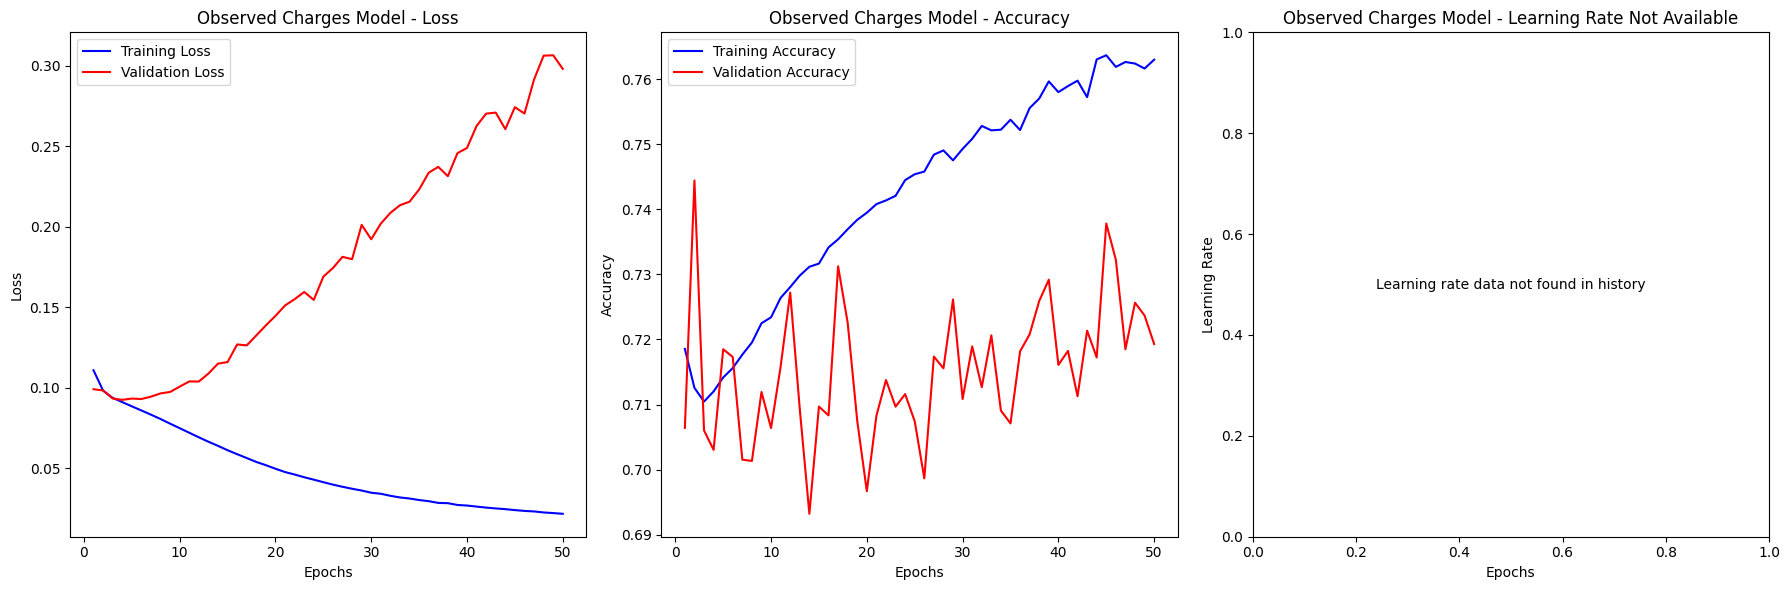

In [35]:
plot_learning_curves(observed_charges_model_history, title='Observed Charges Model')

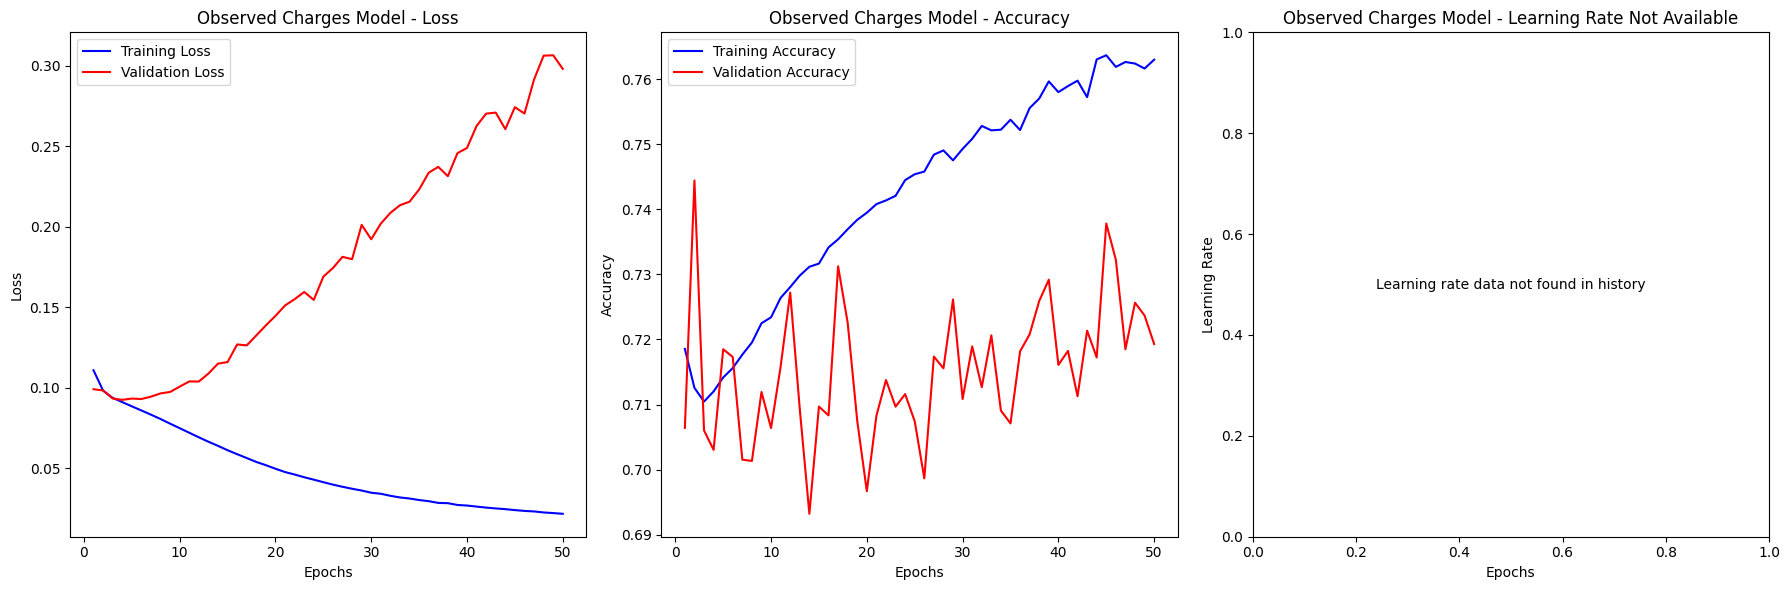

In [43]:
plot_learning_curves(observed_charges_model_history, title='Observed Charges Model')

In [46]:
def evaluate_model(model, X_test, y_test):
    # Predict classes
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print('#################################')
    print(model.summary())
    print('#################################')
    # Print the classification report
    print(classification_report(y_true, y_pred_classes))
    print('#################################')
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    print("Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(y_true)))
    plt.xticks(tick_marks, np.unique(y_true), rotation=45)
    plt.yticks(tick_marks, np.unique(y_true))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

3324/3324 [==============================] - 3s 1ms/step
#################################
Model: "dominant_charge_state_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  352       
                                                                 
 sequential (Sequential)     (None, 19, 512)           406272    
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 sequential_1 (Sequential)   (None, 64)                1253568   
                                                                 
 dense_2 (Dense)             multiple                  390       
                                                                 
Total params: 1660582 (6.33 MB)
Trainable params: 1660582 (6.33 MB)
Non-trai

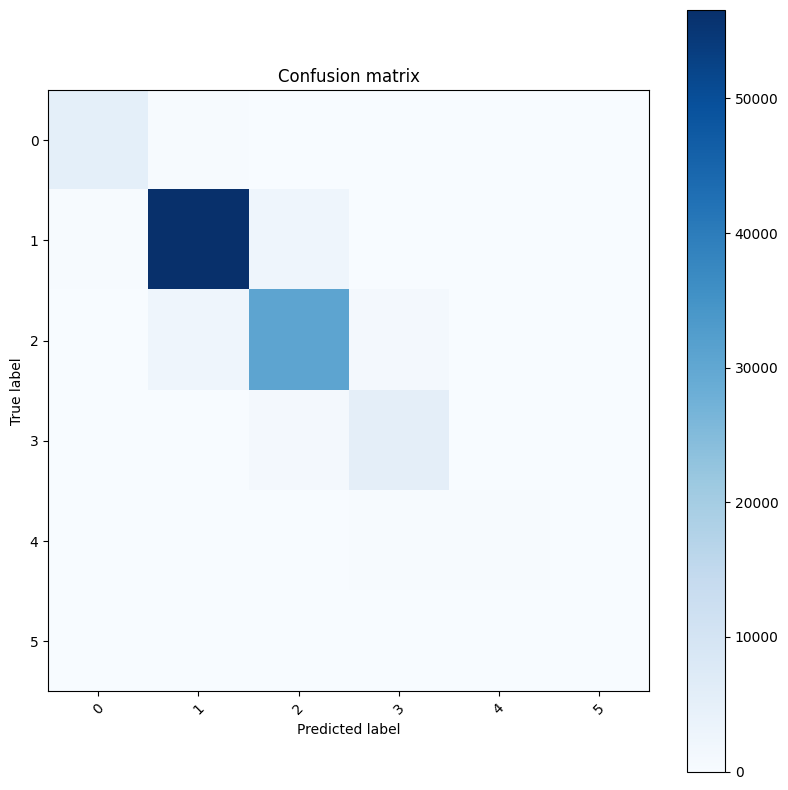

In [48]:
evaluate_model(majority_charge_model, majority_X_test, majority_y_test)

In [ ]:
prosit_adaption_model = PrositChargeStateAdaption(seq_length=max_len)
prosit_adaption_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

majority_model_2 = DominantChargeStatePredictorTest(num_classes=6, seq_length=max_len)
majority_model_2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy',metrics=['accuracy'])

majority_model_3 = DominantChargeStatePredictor_nativeAttention(num_classes=6, seq_length=max_len)
majority_model_3.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy',metrics=['accuracy'])